In [1]:
import findspark
findspark.init()
import pyspark

sc = pyspark.SparkContext(master='spark://hd-master:7077',
                          appName='big_data')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/30 13:17:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.dates as mdates

print('Modules are imported.')

Modules are imported.


In [3]:
spark = SQLContext(sc)

/usr/local/spark/python/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [4]:
covid_data = spark.read.option("header", True).csv("hdfs://hd-master:9000/covid-19", inferSchema=True)
covid_data.show(5, truncate=False)

+-----------+----------+---------+---------+------+
|country    |date      |confirmed|recovered|deaths|
+-----------+----------+---------+---------+------+
|afghanistan|2020-01-22|0        |0        |0     |
|afghanistan|2020-01-23|0        |0        |0     |
|afghanistan|2020-01-24|0        |0        |0     |
|afghanistan|2020-01-25|0        |0        |0     |
|afghanistan|2020-01-26|0        |0        |0     |
+-----------+----------+---------+---------+------+
only showing top 5 rows



In [5]:
# Perform necessary data transformations
covid_data = covid_data.withColumn("date", F.to_date("date", "yyyy-MM-dd"))

In [6]:
# Filter data for selected countries
countries = ['china', 'italy', 'us', 'spain']
selected_countries_data = covid_data.filter(covid_data['country'].isin(countries))
selected_countries_data = selected_countries_data.withColumn("date", F.to_date("date"))

# Filter data for June 2021
selected_month_data = selected_countries_data.filter((F.month("date") == 6) & (F.year("date") == 2021))

# Convert 'date' to numerical values for derivative calculation
selected_month_data = selected_month_data.withColumn("date_numeric", F.unix_timestamp("date"))

# Calculate the first derivative of confirmed cases for each country
windowSpec = Window.partitionBy("country").orderBy("date")

selected_month_data = selected_month_data.withColumn("daily_confirmed", F.col("confirmed") - F.lag("confirmed").over(windowSpec))

# Filter out the first day for each country since daily changes will be null
selected_month_data = selected_month_data.filter(~F.isnull("daily_confirmed"))

# Convert PySpark DataFrame to Pandas DataFrame for visualization
pandas_df = selected_month_data.toPandas()

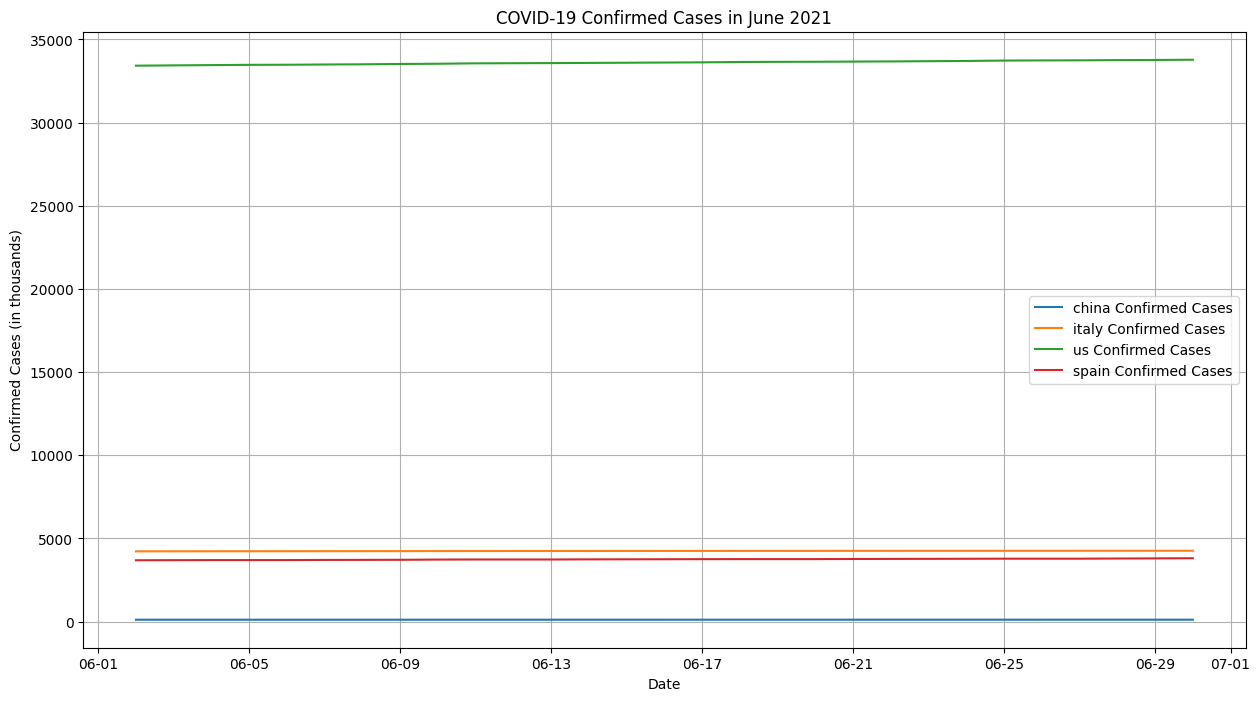

In [7]:
# Visualize confirmed cases
plt.figure(figsize=(15, 8))
for country in countries:
    country_data = pandas_df[pandas_df['country'] == country]
    plt.plot(country_data['date'], country_data['confirmed'], label=f'{country} Confirmed Cases')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title('COVID-19 Confirmed Cases in June 2021')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases (in thousands)')
plt.legend()
plt.grid(True)
plt.show()

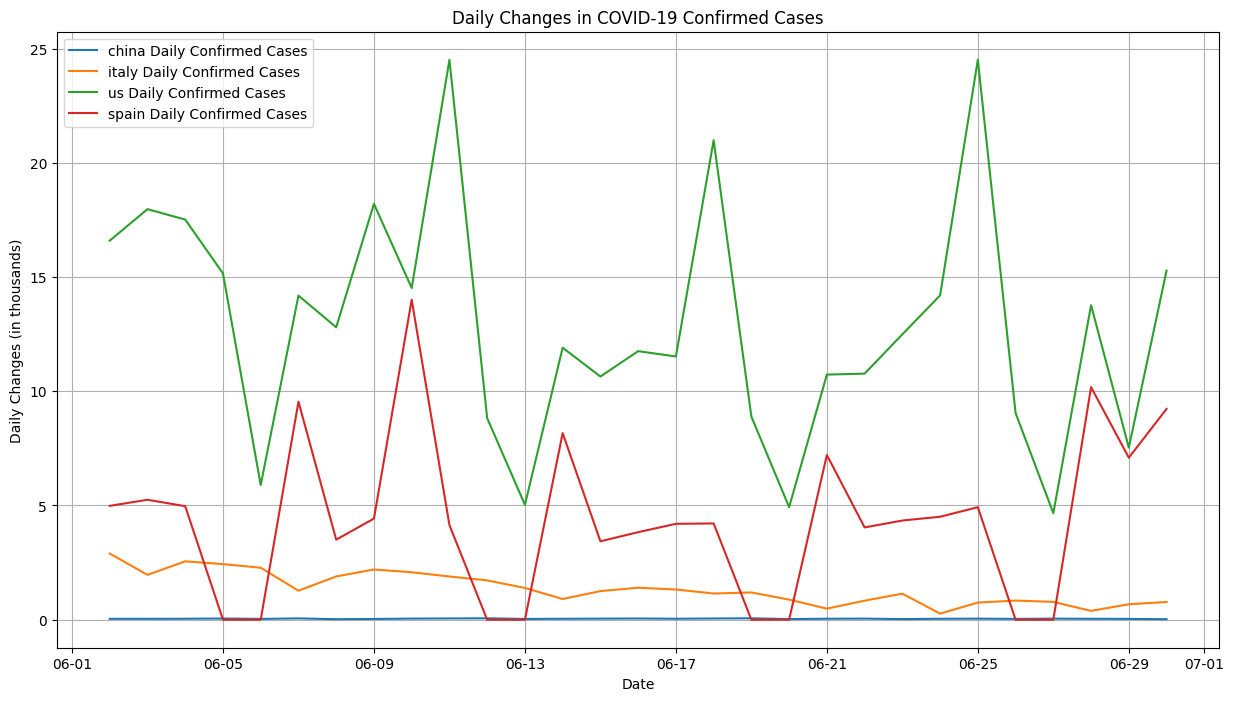

In [8]:
# Visualize daily changes
plt.figure(figsize=(15, 8))
for country in countries:
    country_data = pandas_df[pandas_df['country'] == country]
    plt.plot(country_data['date'], country_data['daily_confirmed'], label=f'{country} Daily Confirmed Cases')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/1000)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.title('Daily Changes in COVID-19 Confirmed Cases')
plt.xlabel('Date')
plt.ylabel('Daily Changes (in thousands)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Stop the Spark session
sc.stop()